In [10]:
import os, re, glob, cv2, csv
import numpy as np
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import tifffile as tiff
import scipy as sp
from scipy import ndimage, io as sio
from scipy.ndimage import maximum_filter, label, find_objects
from scipy.stats import chi2, lognorm, poisson, norm
from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import trackpy as tp
import pandas as pd
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
import matplotlib.colors as mcolors
from tqdm import tqdm
from IPython.display import display, Image

from scipy.stats import wasserstein_distance

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # ignore warnings for specific matplotlib commands which will be outdated soon


In [2]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path with single backslashes to a format with double backslashes for use in Python code.

    Parameters:
    - windows_path: str
        The original Windows file path (e.g., 'C:\\Users\\YourName\\Folder').

    Returns:
    - str
        The modified path with double backslashes, suitable for Python (e.g., 'C:\\\\Users\\\\YourName\\\\Folder').
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")
    

In [166]:
data_folder_glass = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\minimum_10_frames')
data_folder_ridge = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_10_frames')

tp_glass_early = pd.read_csv(data_folder_glass+'\\early_stage.csv')
tp_glass_middle = pd.read_csv(data_folder_glass+'\\middle_stage.csv')
tp_ridge_early = pd.read_csv(data_folder_ridge+'\\early_stage.csv')

In [175]:
tp_ridge_early  = pd.read_csv('E:\\Spandan\\2D_Neurons_Paper\\Ridges\\minimum_3_frames\\early_stage.csv')
tp_ridge_middle  = pd.read_csv('E:\\Spandan\\2D_Neurons_Paper\\Ridges\\minimum_3_frames\\middle_stage.csv')
test = pd.read_csv('E:\\Spandan\\2D_Neurons_Paper\\Ridges\\minimum_10_frames\\early_stage.csv')

In [157]:
tp_glass_early

,Unnamed: 0.1,file_address,Unnamed: 0,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,0,18,7.811891,50.01700,0.317139,0.380438,9.371084,24.632386
1,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,2,221,9.980221,28.00952,1.645486,3.524844,21.378919,6.065211
2,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,3,303,10.286458,22.00748,0.355664,0.969663,28.044441,28.921829
3,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,4,364,4.081012,18.00612,0.735074,2.449415,13.598749,5.551835
4,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,5,404,5.678974,22.00748,3.858001,10.518246,15.482846,1.471999
...,...,...,...,...,...,...,...,...,...,...
512,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div5\\co...,46,5208,10.601570,20.00000,0.428050,1.284149,31.804711,24.767157
513,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div5\\co...,47,5285,8.237938,18.00000,1.368121,4.560403,27.459793,6.021352
514,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div5\\co...,48,5287,8.497422,22.00000,2.560318,6.982685,23.174786,3.318893
515,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div5\\co...,49,5289,6.699625,24.00000,2.379737,5.949343,16.749062,2.815279


In [158]:
tp_ridge_early

,file_address,Unnamed: 0,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,0,250,9.128417,19.99820,1.329168,3.987862,27.387716,6.867769
1,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,1,352,7.695680,21.99802,0.055830,0.152278,20.990108,137.840412
2,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,2,936,2.169729,23.99784,0.183007,0.457558,5.424811,11.856020
3,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,3,1099,7.846036,19.99820,4.234635,12.705050,23.540228,1.852825
4,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,4,1144,4.491120,19.99820,0.112226,0.336708,13.474572,40.018590
...,...,...,...,...,...,...,...,...,...
180,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,13,1685,11.749105,36.02358,0.304479,0.507132,19.569024,38.587610
181,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,14,1712,4.472474,22.01441,0.381899,1.040860,12.189672,11.711156
182,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,15,1899,9.133229,22.01441,1.538460,4.193054,24.892503,5.936605
183,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,16,1950,7.059468,22.01441,0.251825,0.686347,19.240492,28.033196


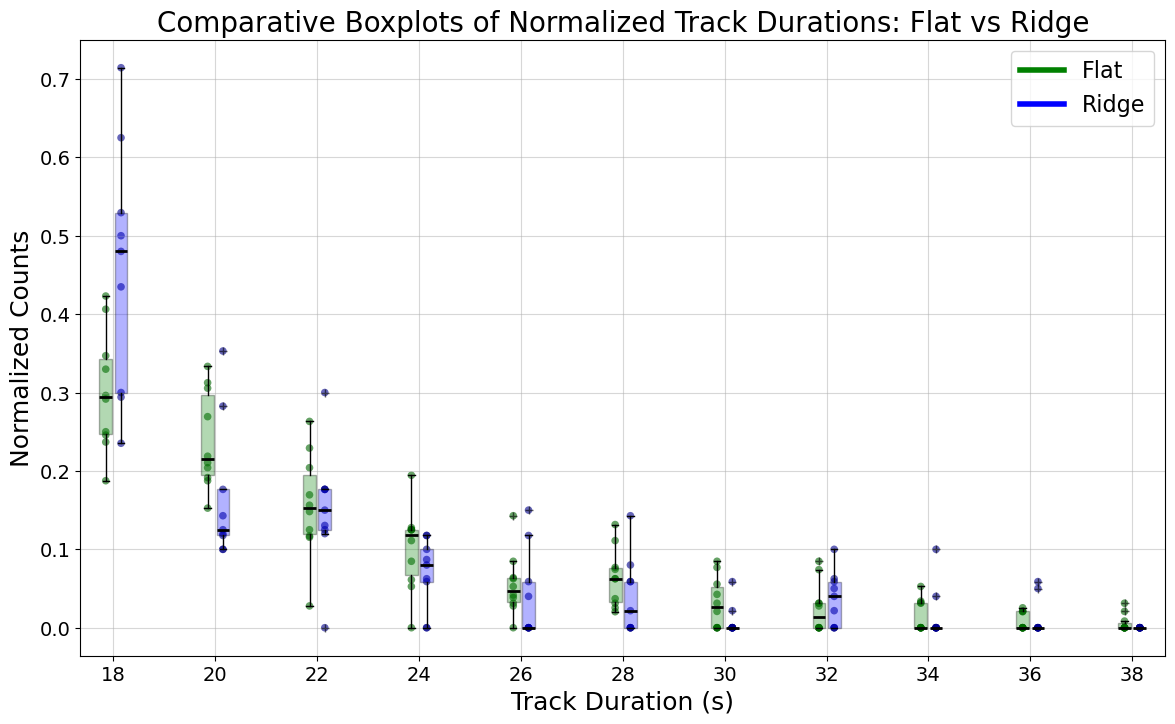

In [159]:
def plot_comparative_boxplots(
    df_glass, df_ridge, data_folder, save_name,
    track_duration_col='track_duration', file_address_col='file_address'
):
    """
    Plot side-by-side boxplots of normalized track durations for glass and ridge data.

    Parameters:
    - df_glass, df_ridge (pandas DataFrame): DataFrames for glass and ridge datasets.
    - data_folder (str): Path to the folder where the SVG file will be saved.
    - save_name (str): Base name for the saved SVG file (without extension).
    - track_duration_col (str, default 'track_duration'): Column with track duration values.
    - file_address_col (str, default 'file_address'): Column with file addresses.

    Returns:
    - None: The function creates and displays a plot, and saves it as an SVG file.
    """

    def compute_normalized_histograms(df, bins):
        """Helper function to compute normalized histograms for a given dataset."""
        histograms = []
        for _, group_data in df.groupby(file_address_col):
            track_durations = group_data[track_duration_col]
            counts, _ = np.histogram(track_durations, bins=bins, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts.astype(float)
            histograms.append(normalized_counts)
        return np.array(histograms).T  # Shape: (bins, files)

    # Define bins
    bins = np.arange(17, 40, 2)  # Define bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Bin centers for plotting

    # Compute normalized histograms for glass and ridge datasets
    hist_glass = compute_normalized_histograms(df_glass, bins)
    hist_ridge = compute_normalized_histograms(df_ridge, bins)

    # Prepare plot
    plt.figure(figsize=(14, 8))
    color_labels = ['green', 'blue']
    scatter_colors = ['darkgreen', 'darkblue']

    # Iterate through bins and plot boxplots
    for idx, (bin_center, glass_values, ridge_values) in enumerate(
        zip(bin_centers, hist_glass, hist_ridge)
    ):
        # Create positions for boxplots
        positions = [bin_center - 0.15, bin_center + 0.15]  # Adjust positions for two datasets

        # Plot scatter points for individual data points
        for pos, values, scatter_color in zip(positions, [glass_values, ridge_values], scatter_colors):
            plt.scatter(
                [pos] * len(values), values, color=scatter_color, alpha=0.6, s=30, edgecolor='none'
            )

        # Plot boxplots
        boxplots = plt.boxplot(
            [glass_values, ridge_values],
            positions=positions,
            widths=0.25,
            patch_artist=True,
            boxprops=dict(color='black', alpha=0.3, linewidth=1),
            medianprops=dict(color='black', linewidth=2),
            flierprops=dict(marker='+', color='red', alpha=0.6)
        )

        # Set colors for each dataset
        for patch, color in zip(boxplots['boxes'], color_labels):
            patch.set_facecolor(color)

    # Add labels, title, and legend
    plt.xticks(bin_centers, [f"{int(c)}" for c in bin_centers], fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Track Duration (s)', fontsize=18)
    plt.ylabel('Normalized Counts', fontsize=18)
    plt.title('Comparative Boxplots of Normalized Track Durations: Flat vs Ridge', fontsize=20)
    plt.grid(True, alpha=0.5)

    # Create a custom legend
    custom_patches = [plt.Line2D([0], [0], color=color, lw=4) for color in color_labels]
    plt.legend(custom_patches, ['Flat', 'Ridge'], loc='upper right', fontsize=16)

    # Save the plot
    if save_name:
        save_path = os.path.join(data_folder, f"{save_name}_track_durations.svg")
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage
plot_comparative_boxplots(
    tp_glass_early, tp_ridge_early,
    data_folder="E:\\Spandan\\2D_Neurons_Paper\\", save_name="glass_vs_ridge_boxplots_10frames",
    track_duration_col='track_duration', file_address_col='file_address'
)


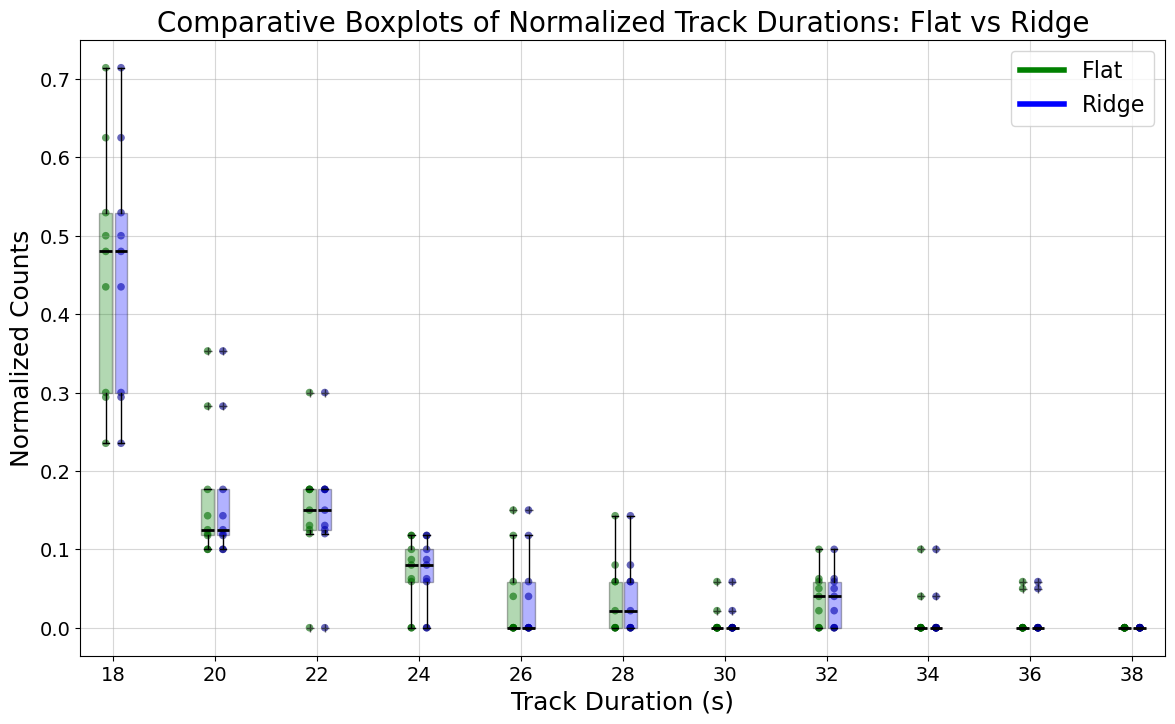

In [75]:
data_folder_glass = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_3_frames')
data_folder_ridge = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_10_frames')

tp_glass_early = pd.read_csv(data_folder_glass+'\\early_stage.csv')
tp_ridge_early = pd.read_csv(data_folder_ridge+'\\early_stage.csv')

def plot_comparative_boxplots(
    df_glass, df_ridge, data_folder, save_name,
    track_duration_col='track_duration', file_address_col='file_address'
):
    """
    Plot side-by-side boxplots of normalized track durations for glass and ridge data.

    Parameters:
    - df_glass, df_ridge (pandas DataFrame): DataFrames for glass and ridge datasets.
    - data_folder (str): Path to the folder where the SVG file will be saved.
    - save_name (str): Base name for the saved SVG file (without extension).
    - track_duration_col (str, default 'track_duration'): Column with track duration values.
    - file_address_col (str, default 'file_address'): Column with file addresses.

    Returns:
    - None: The function creates and displays a plot, and saves it as an SVG file.
    """

    def compute_normalized_histograms(df, bins):
        """Helper function to compute normalized histograms for a given dataset."""
        histograms = []
        for _, group_data in df.groupby(file_address_col):
            track_durations = group_data[track_duration_col]
            counts, _ = np.histogram(track_durations, bins=bins, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts.astype(float)
            histograms.append(normalized_counts)
        return np.array(histograms).T  # Shape: (bins, files)

    # Define bins
    bins = np.arange(17, 40, 2)  # Define bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Bin centers for plotting

    # Compute normalized histograms for glass and ridge datasets
    hist_glass = compute_normalized_histograms(df_glass, bins)
    hist_ridge = compute_normalized_histograms(df_ridge, bins)

    # Prepare plot
    plt.figure(figsize=(14, 8))
    color_labels = ['green', 'blue']
    scatter_colors = ['darkgreen', 'darkblue']

    # Iterate through bins and plot boxplots
    for idx, (bin_center, glass_values, ridge_values) in enumerate(
        zip(bin_centers, hist_glass, hist_ridge)
    ):
        # Create positions for boxplots
        positions = [bin_center - 0.15, bin_center + 0.15]  # Adjust positions for two datasets

        # Plot scatter points for individual data points
        for pos, values, scatter_color in zip(positions, [glass_values, ridge_values], scatter_colors):
            plt.scatter(
                [pos] * len(values), values, color=scatter_color, alpha=0.6, s=30, edgecolor='none'
            )

        # Plot boxplots
        boxplots = plt.boxplot(
            [glass_values, ridge_values],
            positions=positions,
            widths=0.25,
            patch_artist=True,
            boxprops=dict(color='black', alpha=0.3, linewidth=1),
            medianprops=dict(color='black', linewidth=2),
            flierprops=dict(marker='+', color='red', alpha=0.6)
        )

        # Set colors for each dataset
        for patch, color in zip(boxplots['boxes'], color_labels):
            patch.set_facecolor(color)

    # Add labels, title, and legend
    plt.xticks(bin_centers, [f"{int(c)}" for c in bin_centers], fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Track Duration (s)', fontsize=18)
    plt.ylabel('Normalized Counts', fontsize=18)
    plt.title('Comparative Boxplots of Normalized Track Durations: Flat vs Ridge', fontsize=20)
    plt.grid(True, alpha=0.5)

    # Create a custom legend
    custom_patches = [plt.Line2D([0], [0], color=color, lw=4) for color in color_labels]
    plt.legend(custom_patches, ['Flat', 'Ridge'], loc='upper right', fontsize=16)

    # Save the plot
    if save_name:
        save_path = os.path.join(data_folder, f"{save_name}_track_durations.svg")
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage
plot_comparative_boxplots(
    tp_glass_early, tp_ridge_early,
    data_folder="E:\\Spandan\\2D_Neurons_Paper\\", save_name="glass_vs_ridge_boxplots_8frames",
    track_duration_col='track_duration', file_address_col='file_address'
)


In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Function to convert the given path to a code-friendly path format
def convert_to_code_path(path):
    return path.replace("\\", "/")

# Load the ridge data for both 3 frames and 10 frames datasets
data_folder_ridge_3_frames = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_3_frames')
data_folder_ridge_10_frames = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_10_frames')

tp_ridge_3_frames = pd.read_csv(os.path.join(data_folder_ridge_3_frames, 'early_stage.csv'))
tp_ridge_10_frames = pd.read_csv(os.path.join(data_folder_ridge_10_frames, 'early_stage.csv'))

def plot_comparative_boxplots(
    df_ridge_3, df_ridge_10, data_folder, save_name,
    track_duration_col='track_duration', file_address_col='file_address'
):
    """
    Plot side-by-side boxplots of normalized track durations for ridge data with different frame requirements.

    Parameters:
    - df_ridge_3, df_ridge_10 (pandas DataFrame): DataFrames for ridge datasets (3 frames and 10 frames).
    - data_folder (str): Path to the folder where the SVG file will be saved.
    - save_name (str): Base name for the saved SVG file (without extension).
    - track_duration_col (str, default 'track_duration'): Column with track duration values.
    - file_address_col (str, default 'file_address'): Column with file addresses.

    Returns:
    - None: The function creates and displays a plot, and saves it as an SVG file.
    """

    def compute_normalized_histograms(df, bins):
        """Helper function to compute normalized histograms for a given dataset."""
        histograms = []
        for _, group_data in df.groupby(file_address_col):
            track_durations = group_data[track_duration_col]
            counts, _ = np.histogram(track_durations, bins=bins, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts.astype(float)
            histograms.append(normalized_counts)
        return normalized_counts, np.array(histograms).T  # Shape: (bins, files)

    # Define bins
    bins = np.arange(17, 40, 2)  # Define bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Bin centers for plotting

    # Compute normalized histograms for ridge datasets (3 frames and 10 frames)
    hist_ridge_3 = compute_normalized_histograms(df_ridge_3, bins)
    hist_ridge_10 = compute_normalized_histograms(df_ridge_10, bins)

    print (hist_ridge_3-hist_ridge_10) 
    # print (df_ridge_3,df_ridge_10)
    # Prepare plot
    # plt.figure(figsize=(14, 8))
    # color_labels = ['green', 'blue']
    # scatter_colors = ['darkgreen', 'darkblue']

    # # Iterate through bins and plot boxplots
    # for idx, (bin_center, ridge_3_values, ridge_10_values) in enumerate(
    #     zip(bin_centers, hist_ridge_3, hist_ridge_10)
    # ):
    #     # Create positions for boxplots
    #     positions = [bin_center - 0.15, bin_center + 0.15]  # Adjust positions for two datasets

    #     # Plot scatter points for individual data points
    #     for pos, values, scatter_color in zip(positions, [ridge_3_values, ridge_10_values], scatter_colors):
    #         plt.scatter(
    #             [pos] * len(values), values, color=scatter_color, alpha=0.6, s=30, edgecolor='none'
    #         )

    #     # Plot boxplots
    #     boxplots = plt.boxplot(
    #         [ridge_3_values, ridge_10_values],
    #         positions=positions,
    #         widths=0.25,
    #         patch_artist=True,
    #         boxprops=dict(color='black', alpha=0.3, linewidth=1),
    #         medianprops=dict(color='black', linewidth=2),
    #         flierprops=dict(marker='+', color='red', alpha=0.6)
    #     )

    #     # Set colors for each dataset
    #     for patch, color in zip(boxplots['boxes'], color_labels):
    #         patch.set_facecolor(color)

    # # Add labels, title, and legend
    # plt.xticks(bin_centers, [f"{int(c)}" for c in bin_centers], fontsize=14)
    # plt.yticks(fontsize=14)
    # plt.xlabel('Track Duration (s)', fontsize=18)
    # plt.ylabel('Normalized Counts', fontsize=18)
    # plt.title('Comparative Boxplots of Normalized Track Durations: Ridge 3 vs Ridge 10', fontsize=20)
    # plt.grid(True, alpha=0.5)

    # # Create a custom legend
    # custom_patches = [plt.Line2D([0], [0], color=color, lw=4) for color in color_labels]
    # plt.legend(custom_patches, ['Ridge (3 Frames)', 'Ridge (10 Frames)'], loc='upper right', fontsize=16)

    # # Save the plot
    # if save_name:
    #     save_path = os.path.join(data_folder, f"{save_name}_track_durations.svg")
    #     plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage
plot_comparative_boxplots(
    tp_ridge_3_frames, tp_ridge_10_frames,
    data_folder="E:\\Spandan\\2D_Neurons_Paper\\", save_name="ridge_3_vs_ridge_10_boxplots",
    track_duration_col='track_duration', file_address_col='file_address'
)


[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [125]:
tp_ridge_3_frames

,file_address,Unnamed: 0,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,0,2,2.306513,3.99964,1.779399,26.693392,34.600802,1.296231
1,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,1,5,2.501350,3.99964,0.034900,0.523547,37.523621,71.671884
2,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,2,6,4.468231,7.99928,1.409656,10.573370,33.514748,3.169732
3,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,3,18,2.881975,3.99964,2.831974,42.483439,43.233515,1.017656
4,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,4,20,3.033514,5.99946,1.050708,10.508027,30.337867,2.887114
...,...,...,...,...,...,...,...,...,...
6695,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,544,2153,2.771498,4.00262,0.403948,6.055252,41.545262,6.861030
6696,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,545,2156,2.356934,4.00262,2.354370,35.292440,35.330864,1.001089
6697,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,547,2161,2.429749,4.00262,2.250409,33.734039,36.422372,1.079692
6698,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,548,2168,1.372389,4.00262,1.330910,19.950579,20.572357,1.031166


In [124]:
tp_ridge_10_frames

,file_address,Unnamed: 0,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,0,250,9.128417,19.99820,1.329168,3.987862,27.387716,6.867769
1,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,1,352,7.695680,21.99802,0.055830,0.152278,20.990108,137.840412
2,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,2,936,2.169729,23.99784,0.183007,0.457558,5.424811,11.856020
3,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,3,1099,7.846036,19.99820,4.234635,12.705050,23.540228,1.852825
4,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,4,1144,4.491120,19.99820,0.112226,0.336708,13.474572,40.018590
...,...,...,...,...,...,...,...,...,...
180,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,13,1685,11.749105,36.02358,0.304479,0.507132,19.569024,38.587610
181,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,14,1712,4.472474,22.01441,0.381899,1.040860,12.189672,11.711156
182,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,15,1899,9.133229,22.01441,1.538460,4.193054,24.892503,5.936605
183,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,16,1950,7.059468,22.01441,0.251825,0.686347,19.240492,28.033196


In [92]:
data_folder_ridge_3_frames = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_3_frames')
data_folder_ridge_10_frames = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_10_frames')

tp_ridge_3_frames = pd.read_csv(os.path.join(data_folder_ridge_3_frames, 'early_stage.csv'))
tp_ridge_10_frames = pd.read_csv(os.path.join(data_folder_ridge_10_frames, 'early_stage.csv'))

def plot_comparative_boxplots(
    df_ridge_3, df_ridge_10, data_folder, save_name,
    track_duration_col='track_duration', file_address_col='file_address'
):
    """
    Plot side-by-side boxplots of normalized track durations for ridge data with different frame requirements.

    Parameters:
    - df_ridge_3, df_ridge_10 (pandas DataFrame): DataFrames for ridge datasets (3 frames and 10 frames).
    - data_folder (str): Path to the folder where the SVG file will be saved.
    - save_name (str): Base name for the saved SVG file (without extension).
    - track_duration_col (str, default 'track_duration'): Column with track duration values.
    - file_address_col (str, default 'file_address'): Column with file addresses.

    Returns:
    - None: The function creates and displays a plot, and saves it as an SVG file.
    """

    def compute_normalized_histograms(df, bins):
        """Helper function to compute normalized histograms for a given dataset."""
        histograms = []
        for _, group_data in df.groupby(file_address_col):
            track_durations = group_data[track_duration_col]
            counts, _ = np.histogram(track_durations, bins=bins, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts.astype(float)
            histograms.append(normalized_counts)
        return np.array(histograms).T  # Shape: (bins, files)

    # Define bins
    bins = np.arange(17, 40, 2)  # Define bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Bin centers for plotting

    # Compute normalized histograms for ridge datasets (3 frames and 10 frames)
    hist_ridge_3 = compute_normalized_histograms(df_ridge_3, bins)
    hist_ridge_10 = compute_normalized_histograms(df_ridge_10, bins)

    print (hist_ridge_3-hist_ridge_10) 

    # Show the plot
    plt.show()

# Example usage
plot_comparative_boxplots(
    tp_ridge_3_frames, tp_ridge_10_frames,
    data_folder="E:\\Spandan\\2D_Neurons_Paper\\", save_name="ridge_3_vs_ridge_10_boxplots",
    track_duration_col='track_duration', file_address_col='file_address')

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [129]:
cts, yo = compute_normalized_histograms(tp_ridge_10_frames, bins)
cts

array([0.29411765, 0.17647059, 0.17647059, 0.11764706, 0.11764706,
       0.05882353, 0.        , 0.        , 0.        , 0.05882353,
       0.        ])

In [130]:
cts2, yo2 = compute_normalized_histograms(tp_ridge_3_frames, bins)
cts2

array([0.29411765, 0.17647059, 0.17647059, 0.11764706, 0.11764706,
       0.05882353, 0.        , 0.        , 0.        , 0.05882353,
       0.        ])

In [162]:
bins = np.arange(17, 40, 2) 
cts1, hist_1 = compute_normalized_histograms(tp_glass_early,bins=np.arange(17, 40, 2),track_duration_col='track_duration', file_address_col='file_address')
hist_1[0]

array([0.1875    , 0.40625   , 0.42307692, 0.24576271, 0.32978723,
       0.29166667, 0.25      , 0.2962963 , 0.23684211, 0.34693878])

In [161]:
bins = np.arange(17, 40, 2) 
cts2, hist_2 = compute_normalized_histograms(tp_ridge_10_frames,bins=np.arange(17, 40, 2),track_duration_col='track_duration', file_address_col='file_address')
hist_2[0]

array([0.625     , 0.52941176, 0.23529412, 0.3       , 0.43478261,
       0.48      , 0.5       , 0.71428571, 0.29411765])

In [126]:
def compute_normalized_histograms(df, bins, track_duration_col='track_duration', file_address_col='file_address'):
    """
    Helper function to compute normalized histograms for a given dataset.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame containing track duration data and file addresses.
    - bins (array-like): The bins to use for the histogram calculation.
    - track_duration_col (str, default 'track_duration'): The column in the DataFrame containing the track durations.
    - file_address_col (str, default 'file_address'): The column in the DataFrame representing file addresses (or other grouping variable).

    Returns:
    - numpy.ndarray: A 2D array where each column corresponds to the normalized histogram of track durations for a specific file 
      (or group as determined by `file_address_col`), and the rows correspond to the bins.

    Notes:
    - The histogram is normalized by dividing by the sum of the counts in each histogram (if the sum is non-zero).
    - If the sum of counts is zero, the counts are returned as-is.
    """
    
    histograms = []
    
    # Group data by file address (or any other grouping variable) and compute histograms
    for _, group_data in df.groupby(file_address_col):
        track_durations = group_data[track_duration_col]
        
        # Compute the histogram of track durations
        counts, _ = np.histogram(track_durations, bins=bins, density=False)
        
        # Normalize the histogram by dividing by the total count, if it's non-zero
        if counts.sum() > 0:
            normalized_counts = counts / counts.sum()
        else:
            normalized_counts = counts.astype(float)  # If sum is zero, return the counts as-is
        
        # Append the normalized histogram for the current group
        histograms.append(normalized_counts)
    
    # Convert the list of histograms into a 2D numpy array
    return normalized_counts, np.array(histograms).T  # Shape: (bins, files)


bins = np.arange(17, 40, 2)  # Define bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Bin centers for plotting
file_address_col='file_address'
track_duration_col='track_duration'

In [112]:
tp_ridge_3_frames

,file_address,Unnamed: 0,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,0,2,2.306513,3.99964,1.779399,26.693392,34.600802,1.296231
1,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,1,5,2.501350,3.99964,0.034900,0.523547,37.523621,71.671884
2,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,2,6,4.468231,7.99928,1.409656,10.573370,33.514748,3.169732
3,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,3,18,2.881975,3.99964,2.831974,42.483439,43.233515,1.017656
4,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,4,20,3.033514,5.99946,1.050708,10.508027,30.337867,2.887114
...,...,...,...,...,...,...,...,...,...
6695,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,544,2153,2.771498,4.00262,0.403948,6.055252,41.545262,6.861030
6696,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,545,2156,2.356934,4.00262,2.354370,35.292440,35.330864,1.001089
6697,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,547,2161,2.429749,4.00262,2.250409,33.734039,36.422372,1.079692
6698,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,548,2168,1.372389,4.00262,1.330910,19.950579,20.572357,1.031166


In [113]:
tp_ridge_10_frames

,file_address,Unnamed: 0,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,0,250,9.128417,19.99820,1.329168,3.987862,27.387716,6.867769
1,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,1,352,7.695680,21.99802,0.055830,0.152278,20.990108,137.840412
2,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,2,936,2.169729,23.99784,0.183007,0.457558,5.424811,11.856020
3,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,3,1099,7.846036,19.99820,4.234635,12.705050,23.540228,1.852825
4,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,4,1144,4.491120,19.99820,0.112226,0.336708,13.474572,40.018590
...,...,...,...,...,...,...,...,...,...
180,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,13,1685,11.749105,36.02358,0.304479,0.507132,19.569024,38.587610
181,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,14,1712,4.472474,22.01441,0.381899,1.040860,12.189672,11.711156
182,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,15,1899,9.133229,22.01441,1.538460,4.193054,24.892503,5.936605
183,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,16,1950,7.059468,22.01441,0.251825,0.686347,19.240492,28.033196


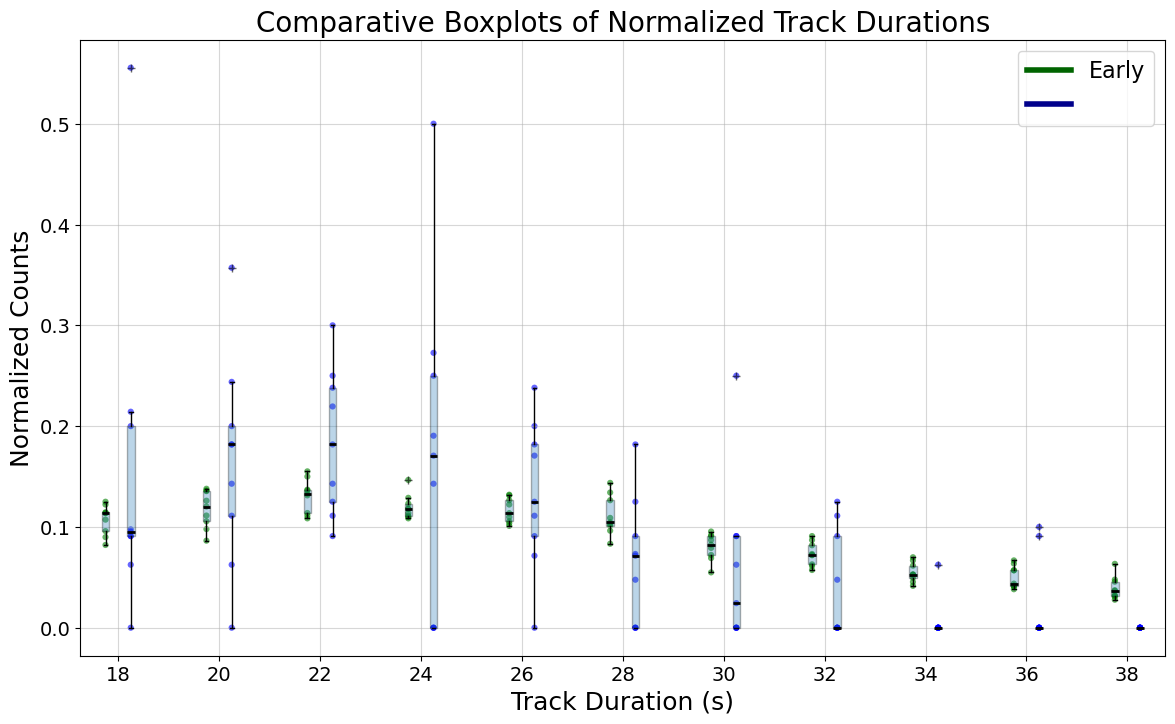

In [191]:
def plot_comparative_boxplots(
    df_1, df_2, data_folder, save_name,
    track_duration_col='track_duration', file_address_col='file_address'
):
    """
    Plot side-by-side boxplots of normalized track durations for two datasets.

    Parameters:
    - df_1, df_2 (pandas DataFrame): DataFrames for two phases or groups to compare.
    - data_folder (str): Path to the folder where the SVG file will be saved.
    - save_name (str): Base name for the saved SVG file (without extension).
    - track_duration_col (str, default 'track_duration'): Column with track duration values.
    - file_address_col (str, default 'file_address'): Column with file addresses.

    Returns:
    - None: The function creates and displays a plot, and saves it as an SVG file.
    """
    
    def compute_normalized_histograms(df, bins, track_duration_col, file_address_col):
        """Helper function to compute normalized histograms for a given dataset."""
        histograms = []
        for _, group_data in df.groupby(file_address_col):
            track_durations = group_data[track_duration_col]
            counts, _ = np.histogram(track_durations, bins=bins, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts.astype(float)
            histograms.append(normalized_counts)
        return np.array(histograms).T  # Shape: (bins, files)

    # Define bins and bin centers for plotting
    bins = np.arange(17, 40, 2)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Bin centers for plotting

    # Compute normalized histograms for each dataset
    hist_1 = compute_normalized_histograms(df_1, bins, track_duration_col, file_address_col)
    hist_2 = compute_normalized_histograms(df_2, bins, track_duration_col, file_address_col)

    # print (hist_1,hist_2)
    # Prepare plot
    plt.figure(figsize=(14, 8))
    color_labels = ['darkgreen', 'darkblue']
    error_color_labels = ['green', 'blue']

    # Plot the boxplots for Dataset 1 and Dataset 2
    positions_1 = bin_centers - 0.25
    positions_2 = bin_centers + 0.25

    # Plot Dataset 1
    plt.boxplot(hist_1.T, positions=positions_1, widths=0.15, patch_artist=True,
                boxprops=dict(color='black', alpha=0.3), medianprops=dict(color='black', linewidth=2),
                flierprops=dict(marker='+', color='red', alpha=0.6))

    # Plot Dataset 2
    plt.boxplot(hist_2.T, positions=positions_2, widths=0.15, patch_artist=True,
                boxprops=dict(color='black', alpha=0.3), medianprops=dict(color='black', linewidth=2),
                flierprops=dict(marker='+', color='red', alpha=0.6))

    # Customize colors for each dataset
    for patch, color in zip(plt.gca().artists, color_labels):
        patch.set_facecolor(color)

    # Add scatter points for individual data points (optional)
    for idx, (values_1, values_2) in enumerate(zip(hist_1, hist_2)):
        # Plot scatter points for individual values in Dataset 1
        for value in values_1:
            plt.scatter(positions_1[idx], value, color='green', alpha=0.6, s=20, edgecolor='none')
        # Plot scatter points for individual values in Dataset 2
        for value in values_2:
            plt.scatter(positions_2[idx], value, color='blue', alpha=0.6, s=20, edgecolor='none')

    # Add labels, title, and legend
    plt.xticks(bin_centers, [f"{int(c)}" for c in bin_centers], fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Track Duration (s)', fontsize=18)
    plt.ylabel('Normalized Counts', fontsize=18)
    plt.title('Comparative Boxplots of Normalized Track Durations', fontsize=20)
    plt.grid(True, alpha=0.5)

    # Create a custom legend
    custom_patches = [plt.Line2D([0], [0], color=color, lw=4) for color in color_labels]
    plt.legend(custom_patches, ['Early', ''], loc='upper right', fontsize=16)

    # Save the plot
    if save_name:
        save_path = os.path.join(data_folder, f"{save_name}_track_durations.svg")
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage
# Assuming 'tp_trajectories_1' and 'tp_trajectories_2' are the dataframes you want to compare.
data_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges'
plot_comparative_boxplots(
    tp_ridge_early, test,
    data_folder=data_folder, save_name="comparative_boxplots_track_duration",
    track_duration_col='inst_velocity', file_address_col='file_address'
)


In [179]:
test

,file_address,Unnamed: 0,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,0,250,9.128417,19.99820,1.329168,3.987862,27.387716,6.867769
1,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,1,352,7.695680,21.99802,0.055830,0.152278,20.990108,137.840412
2,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,2,936,2.169729,23.99784,0.183007,0.457558,5.424811,11.856020
3,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,3,1099,7.846036,19.99820,4.234635,12.705050,23.540228,1.852825
4,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div2\\r...,4,1144,4.491120,19.99820,0.112226,0.336708,13.474572,40.018590
...,...,...,...,...,...,...,...,...,...
180,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,13,1685,11.749105,36.02358,0.304479,0.507132,19.569024,38.587610
181,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,14,1712,4.472474,22.01441,0.381899,1.040860,12.189672,11.711156
182,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,15,1899,9.133229,22.01441,1.538460,4.193054,24.892503,5.936605
183,E:\\Spandan\\2D_Neurons_Paper\\Ridges\\div4\\r...,16,1950,7.059468,22.01441,0.251825,0.686347,19.240492,28.033196


(array([109.,  40.,   7.,   8.,   6.,   5.,   1.,   3.,   3.,   3.]),
 array([17.99838 , 21.199392, 24.400404, 27.601416, 30.802428, 34.00344 ,
        37.204452, 40.405464, 43.606476, 46.807488, 50.0085  ]),
 <BarContainer object of 10 artists>)

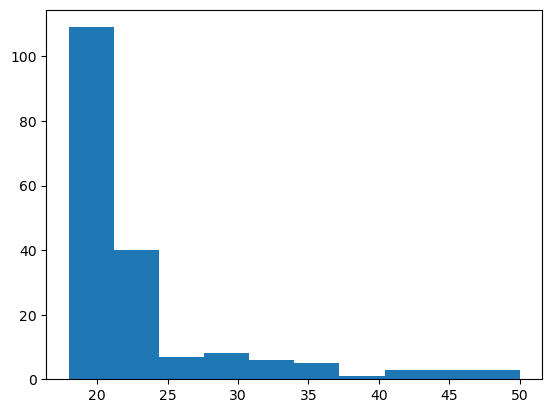

In [181]:
plt.hist(test['track_duration'])

(array([5.462e+03, 7.860e+02, 2.670e+02, 1.350e+02, 2.100e+01, 8.000e+00,
        1.100e+01, 1.000e+00, 4.000e+00, 5.000e+00]),
 array([ 3.99964 ,  8.600526, 13.201412, 17.802298, 22.403184, 27.00407 ,
        31.604956, 36.205842, 40.806728, 45.407614, 50.0085  ]),
 <BarContainer object of 10 artists>)

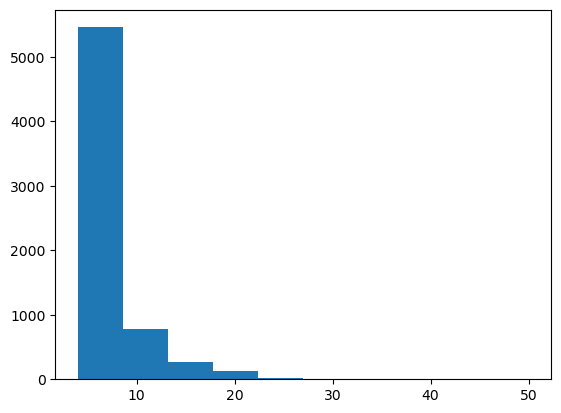

In [186]:
plt.hist(tp_ridge_early['track_duration'])
# plt.xlim([18 50])

In [187]:
def compute_normalized_histograms(df, bins, track_duration_col, file_address_col):
    """Helper function to compute normalized histograms for a given dataset."""
    histograms = []
    for _, group_data in df.groupby(file_address_col):
        track_durations = group_data[track_duration_col]
        counts, _ = np.histogram(track_durations, bins=bins, density=False)
        normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts.astype(float)
        histograms.append(normalized_counts)
    return np.array(histograms).T  # Shape: (bins, files)
cts2, yo2 = compute_normalized_histograms(tp_ridge_early, bins)
cts2

array([0.29411765, 0.17647059, 0.17647059, 0.11764706, 0.11764706,
       0.05882353, 0.        , 0.        , 0.        , 0.05882353,
       0.        ])

In [188]:
cts, yo = compute_normalized_histograms(test, bins)
cts

array([0.29411765, 0.17647059, 0.17647059, 0.11764706, 0.11764706,
       0.05882353, 0.        , 0.        , 0.        , 0.05882353,
       0.        ])

In [189]:
bins

array([17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39])